##Machine Translation Using a Seq2Seq Architecture
© 2023, Zaka AI, Inc. All Rights Reserved.

---
The goal of this colab is to get you more familiar with the Seq2Seq models and their challenges. For this reason, you will be working on machine translation problem where we would have a sentence as input (in english), and the output is gonna be the translated sentence (in french). So just like what happens with Google Translate.


**Just to give you a heads up:** We won't be having a model performing like Google translate, but at least we will have an idea about how Google Translate works and the challenges that exist with a translation problem.  

## Importing Libraries

We start by importing numpy and pandas and then we can add the rest

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (
    Input,
    LSTM,
    Masking,
    Dense,
    Embedding,
    RepeatVector,
    Activation,
    TimeDistributed
)
from tensorflow.keras.models import Model
from tensorflow.keras.utils import pad_sequences as pds
from tensorflow.keras.layers import TextVectorization as TV
from tensorflow.keras.callbacks import EarlyStopping

We clone the github repository where our data exists. Here is the github link: https://github.com/zaka-ai/machine_learning_certification/tree/main/Challenge%207 

## Getting the data

In [2]:
!git clone https://github.com/zaka-ai/machine_learning_certification

Cloning into 'machine_learning_certification'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 43 (delta 10), reused 10 (delta 1), pack-reused 0
Unpacking objects: 100% (43/43), 43.23 MiB | 5.15 MiB/s, done.


We read the english sentences in a dataframe named "english", and the french sentences in a dataframe named "french"

In [3]:
eng_path = '/content/machine_learning_certification/Challenge 7/en.csv'
english = pd.read_csv(eng_path, header=None)
english.head()

,0
0,"new jersey is sometimes quiet during autumn , ..."
1,the united states is usually chilly during jul...
2,"california is usually quiet during march , and..."
3,the united states is sometimes mild during jun...
4,"your least liked fruit is the grape , but my l..."


In [4]:
fren_path = '/content/machine_learning_certification/Challenge 7/fr.csv'
french = pd.read_csv(fren_path, header=None)
french.head()

,0
0,new jersey est parfois calme pendant l' automn...
1,les états-unis est généralement froid en juill...
2,"california est généralement calme en mars , et..."
3,"les états-unis est parfois légère en juin , et..."
4,"votre moins aimé fruit est le raisin , mais mo..."


**How many sentences does each of the files contain?**

In [5]:
print(english.info())
print('\n' + '####################################' + '\n')
print(french.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137860 entries, 0 to 137859
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   0       137860 non-null  object
dtypes: object(1)
memory usage: 1.1+ MB
None

####################################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137860 entries, 0 to 137859
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   0       137860 non-null  object
dtypes: object(1)
memory usage: 1.1+ MB
None


Now let us concatenate the 2 dataframes into one dataframe that we call **df** where one column has the english senetnces and the other has the french sentences

In [6]:
df = pd.concat([english, french], axis=1)
df.head()

,0,0
0,"new jersey is sometimes quiet during autumn , ...",new jersey est parfois calme pendant l' automn...
1,the united states is usually chilly during jul...,les états-unis est généralement froid en juill...
2,"california is usually quiet during march , and...","california est généralement calme en mars , et..."
3,the united states is sometimes mild during jun...,"les états-unis est parfois légère en juin , et..."
4,"your least liked fruit is the grape , but my l...","votre moins aimé fruit est le raisin , mais mo..."


Let's name the columns as **English** and **French** so that we access them easier.

In [7]:
df.columns = ['English', 'French']
df.head()

,English,French
0,"new jersey is sometimes quiet during autumn , ...",new jersey est parfois calme pendant l' automn...
1,the united states is usually chilly during jul...,les états-unis est généralement froid en juill...
2,"california is usually quiet during march , and...","california est généralement calme en mars , et..."
3,the united states is sometimes mild during jun...,"les états-unis est parfois légère en juin , et..."
4,"your least liked fruit is the grape , but my l...","votre moins aimé fruit est le raisin , mais mo..."


Pick a sentence and print it in both languages

In [8]:
print(f"English sentence: {df.iloc[0, 0]}\nFrench sentence: {df.iloc[0,1]}")

English sentence: new jersey is sometimes quiet during autumn , and it is snowy in april .
French sentence: new jersey est parfois calme pendant l' automne , et il est neigeux en avril .


##Cleaning Data

The data that we have is almost clean as we can see, we just need to remove the punctuations inside of it.

In [9]:
import re 
df['English'] = df['English'].apply(lambda s: ' '.join(re.sub("[.,!?:;-='...@#_]", " ", s).split()))
df['French'] = df['French'].apply(lambda s: ' '.join(re.sub("[.,!?:;-='...@#_]", " ", s).split()))
df.head()

,English,French
0,new jersey is sometimes quiet during autumn an...,new jersey est parfois calme pendant l automne...
1,the united states is usually chilly during jul...,les états-unis est généralement froid en juill...
2,california is usually quiet during march and i...,california est généralement calme en mars et i...
3,the united states is sometimes mild during jun...,les états-unis est parfois légère en juin et i...
4,your least liked fruit is the grape but my lea...,votre moins aimé fruit est le raisin mais mon ...


Make sure that the punctuation is removed by printing the example that you printed earlier.

In [10]:
df.loc[0].values

array(['new jersey is sometimes quiet during autumn and it is snowy in april',
       'new jersey est parfois calme pendant l automne et il est neigeux en avril'],
      dtype=object)

##Exploring the Data

Add a column **ENG Length** to the dataset that shows how many words does a sentence contain, and do the same for french in a column called **FR Length**

In [11]:
df.head()

,English,French
0,new jersey is sometimes quiet during autumn an...,new jersey est parfois calme pendant l automne...
1,the united states is usually chilly during jul...,les états-unis est généralement froid en juill...
2,california is usually quiet during march and i...,california est généralement calme en mars et i...
3,the united states is sometimes mild during jun...,les états-unis est parfois légère en juin et i...
4,your least liked fruit is the grape but my lea...,votre moins aimé fruit est le raisin mais mon ...


In [12]:
# for i in range(len(df['English'])):
#   x = len(df['English'][i])
#   df.at[i, 'ENG_Length'] = x

# for i in range(len(df['French'])):
#   x = len(df['French'][i])
#   df.at[i, 'FR_Length'] = x

df["ENG_Length"] = df["English"].str.split().str.len()
df["FR_Length"] = df["French"].str.split().str.len()

In [13]:
df.head()

,English,French,ENG_Length,FR_Length
0,new jersey is sometimes quiet during autumn an...,new jersey est parfois calme pendant l automne...,13,14
1,the united states is usually chilly during jul...,les états-unis est généralement froid en juill...,15,13
2,california is usually quiet during march and i...,california est généralement calme en mars et i...,13,13
3,the united states is sometimes mild during jun...,les états-unis est parfois légère en juin et i...,14,13
4,your least liked fruit is the grape but my lea...,votre moins aimé fruit est le raisin mais mon ...,14,14


Visualize the distribution of the lengths of english sentences and french sentences.

<Axes: xlabel='ENG_Length', ylabel='Count'>

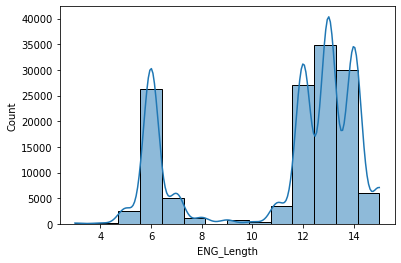

In [14]:
sns.histplot(data=df["ENG_Length"], bins=14, kde=True)

<Axes: xlabel='FR_Length', ylabel='Count'>

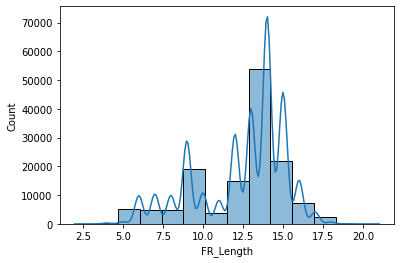

In [15]:
sns.histplot(data=df["FR_Length"], bins=14, kde=True)

It seems that the length (in words) distribution of English sentences has a bimodal shape, having peaks at 6 and 13 respectively. That is to say that sentences of lengths around 6 and 13 are most frequent.
The same property carries on to French sentences length distribution, but with the first peak being at around 10, with less frequency of sentences at this length, and higher frequency at around 13.

Get the maximum length of an english sentence and the maximum length of a french sentence. 

In [16]:
print(f"Maximum word length of an English sentence: {df['ENG_Length'].max()}")
print(f"Maximum word length of a French sentence: {df['FR_Length'].max()}")

Maximum word length of an English sentence: 15
Maximum word length of a French sentence: 21


Case Normalization Sanity Check:

In [17]:
df["English"].str.isupper().sum(), df["French"].str.isupper().sum()

(0, 0)

It seems that all sentences have a normalized case

Let's check for numerical characters in the corpus:

In [18]:
df["English"].str.isnumeric().sum(), df["French"].str.isnumeric().sum()

(0, 0)

No numerical characters detected in the text

Let's visualize a wordcloud to see what content do we have in our data:

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


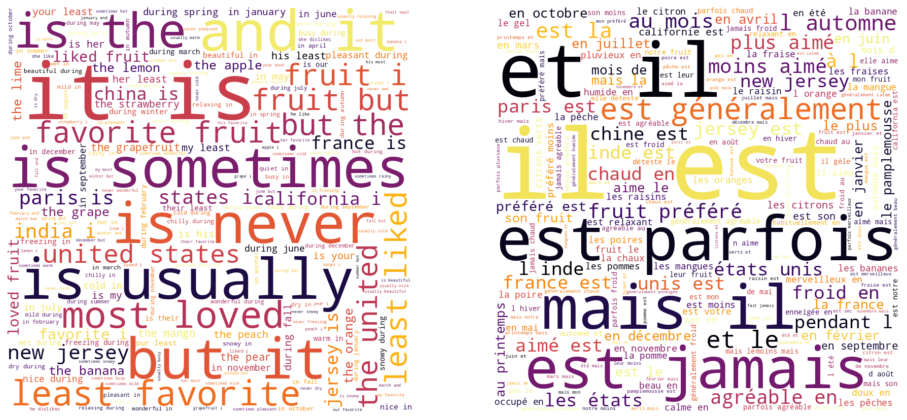

In [19]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
# Example sentences
def vis_wordcloud(en_stopwords, fr_stopwords):
    eng_sentences = " ".join(df["English"].to_list())
    fr_sentences = " ".join(df["French"].to_list())
    # Generate wordcloud
    en_wordcloud = WordCloud(width=800, height=800, background_color="white", colormap="inferno", stopwords=en_stopwords).generate(eng_sentences)
    fr_wordcloud = WordCloud(width=800, height=800, background_color="white", colormap="inferno", stopwords=fr_stopwords).generate(fr_sentences)

    # Display the generated image:
    fig, ax = plt.subplots(1, 2, figsize=(16,16))

    ax[0].imshow(en_wordcloud, interpolation="bilinear")
    ax[1].imshow(fr_wordcloud, interpolation="bilinear")

    ax[0].axis("off")
    ax[1].axis("off")

    plt.show()


vis_wordcloud(set(), set())

As expected, stopwords are highly present in the data. However, of course we cannot remove them otherwise the model will not perform well in translation. Lets visualize the corpus without the stop words to have a better idea of non-stopwords content:

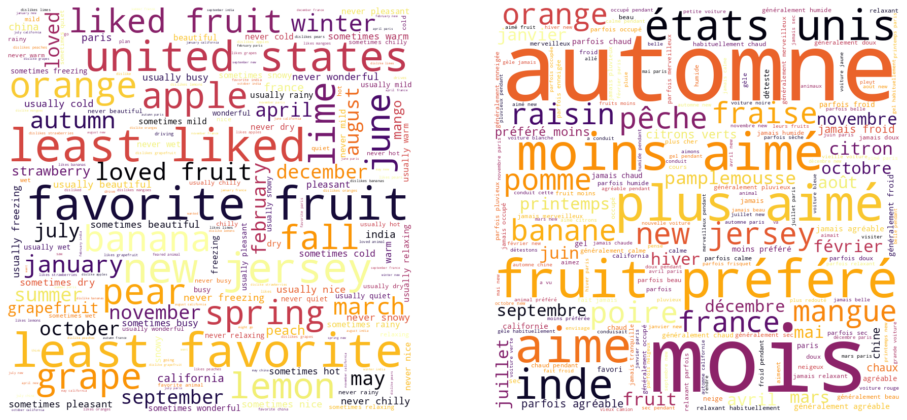

In [20]:
vis_wordcloud(None, stopwords.words('french'))

The corpus seems juicy!

##Preprocessing the Data

In order for the data to be fed to the model, it has to be tokenized and padded. 

####Tokenization

**To tokenize english and french sentences, we can use only one tokenizer. True or False?**

In general, yes we can use the same tokenizer for the two languages as long as the tokenizer is made to handle those two languages. In fact, this is the case for some BERT and GPT models where they can handle multilingual text. However, as tokenization aims to extract the linguistically meaningful units (LMU) from text, and as each language has its own linguistic properties, some languages may be delimited simply by space (English for e.g., well not always) and others may admit the fact that one token may be a combination of two words. Hence, and depending on each use-case, it may be better to use a tokenizer that is specialized for one language.

In our case, lets use the famous punkt tokenizer that supports multiple languages, including English and French:

Tokenize the sentences that we have.

In [21]:
from nltk.tokenize import word_tokenize
nltk.download("punkt")


df["English_tok"] = df["English"].apply(word_tokenize)
df["French_tok"] = df["French"].apply(word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


let's examine some tokenized sentences:

In [22]:
df[["English_tok"]].head(10)

,English_tok
0,"[new, jersey, is, sometimes, quiet, during, au..."
1,"[the, united, states, is, usually, chilly, dur..."
2,"[california, is, usually, quiet, during, march..."
3,"[the, united, states, is, sometimes, mild, dur..."
4,"[your, least, liked, fruit, is, the, grape, bu..."
5,"[his, favorite, fruit, is, the, orange, but, m..."
6,"[paris, is, relaxing, during, december, but, i..."
7,"[new, jersey, is, busy, during, spring, and, i..."
8,"[our, least, liked, fruit, is, the, lemon, but..."
9,"[the, united, states, is, sometimes, busy, dur..."


In [23]:
df[["French_tok"]].head(10)

,French_tok
0,"[new, jersey, est, parfois, calme, pendant, l,..."
1,"[les, états-unis, est, généralement, froid, en..."
2,"[california, est, généralement, calme, en, mar..."
3,"[les, états-unis, est, parfois, légère, en, ju..."
4,"[votre, moins, aimé, fruit, est, le, raisin, m..."
5,"[son, fruit, préféré, est, l, orange, mais, mo..."
6,"[paris, est, relaxant, en, décembre, mais, il,..."
7,"[new, jersey, est, occupé, au, printemps, et, ..."
8,"[notre, fruit, est, moins, aimé, le, citron, m..."
9,"[les, états-unis, est, parfois, occupé, en, ja..."


Seems fair.

**How many unique words do we have in english and in french?**

It is not very accurate to assume that we can correctly count the number of "words" in our corpus, simply by demiliting the text by space. Simply, the presence of forms such as contractions in language will contribute to the inaccurate results. Similarly, we can't do that by counting tokens because not all tokens are meaningful words by themselves. All in all, let's count how many unique token we have:

English unique word count: {'new': 12197, 'jersey': 11225, 'is': 205858, 'sometimes': 37746, 'quiet': 8693, 'during': 74933, 'autumn': 9004, 'and': 59850, 'it': 75377, 'snowy': 8898, 'in': 75525, 'april': 8954, 'the': 67628, 'united': 11270, 'states': 11270, 'usually': 37507, 'chilly': 8770, 'july': 8956, 'freezing': 8928, 'november': 8951, 'california': 11250, 'march': 9023, 'hot': 8639, 'june': 9133, 'mild': 8743, 'cold': 8878, 'september': 8958, 'your': 9734, 'least': 27564, 'liked': 14046, 'fruit': 27192, 'grape': 4848, 'but': 63987, 'my': 9700, 'apple': 4848, 'his': 9700, 'favorite': 28332, 'orange': 4848, 'paris': 11334, 'relaxing': 8696, 'december': 8945, 'busy': 8791, 'spring': 9102, 'never': 37500, 'our': 8932, 'lemon': 4848, 'january': 9090, 'warm': 8890, 'lime': 4848, 'her': 9700, 'banana': 4848, 'he': 10786, 'saw': 648, 'a': 1944, 'old': 972, 'yellow': 972, 'truck': 1944, 'india': 11277, 'rainy': 8761, 'that': 2712, 'cat': 192, 'was': 1867, 'most': 14934, 'loved': 14166, 'a

<Axes: >

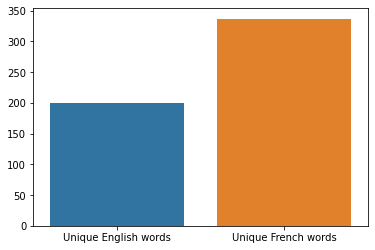

In [24]:
ENG_results = Counter()
FR_results = Counter()

df["English_tok"].apply(ENG_results.update)
print(f"English unique word count: {dict(ENG_results)}")

df["French_tok"].apply(FR_results.update)
print(f"French unique word count: {dict(FR_results)}")
sns.barplot(x=["Unique English words", "Unique French words"], y=[len(ENG_results), len(FR_results)])


####Padding

**What should be the length of the sequences that we have after padding?**

Perform padding on the sequences that we have.

In [25]:
df["English_tok"].apply(len).max(), df["French_tok"].apply(len).max()

(15, 21)

We have maximum token length for english sentences as 15 and for French sentences as 21 token.

In [26]:
max_length_ENG = 15
max_length_FR = 21

def vectorize(vocabulary: list):
    layer = TV(vocabulary=vocabulary)
    return layer

input_vectorizer = vectorize(list(ENG_results))
output_vectorizer = vectorize(list(FR_results))


in_vocab_size = len(input_vectorizer.get_vocabulary())
out_vocab_size = len(output_vectorizer.get_vocabulary())

In [27]:
print(f"Max length of an english sentence: {max_length_ENG}")
print(f"English vocabulary size: {in_vocab_size}")

print(f"Max length of a french sentence: {max_length_FR}")
print(f"French vocabulary size: {out_vocab_size}")

Max length of an english sentence: 15
English vocabulary size: 202
Max length of a french sentence: 21
French vocabulary size: 339


We already we have our text tokenized, we need to map tokens to ids (integers), and supply the vocabulary we already had.

**Note: the TextVectorization layer produces by default sequences that are padded to the maximum sequence of the input**

##Modeling

After preprocessing the data, we can build our model. Start by building a baseline architecture relying on one directional RNNs, LSTMs, or GRUs. It will be good to lookup how to build Seq2Seq models, there are some new layers that will help you like RepeatVector and TimeDistributed.

In [28]:
# creating model layers

input_sequence = Input(shape=(max_length_ENG,))

embedding = Embedding(
    input_dim=in_vocab_size,
    output_dim=128,
    embeddings_initializer=tf.keras.initializers.GlorotUniform,
    mask_zero=True
)

encoder = LSTM(64, return_sequences=False)
repeat_vector = RepeatVector(max_length_FR)
decoder = LSTM(64, return_sequences=True, dropout=0.2)
logits = TimeDistributed(Dense(out_vocab_size))
output_layer = Dense(out_vocab_size, activation='softmax')


# Build the model
x = input_sequence
x = embedding(x)
x = Masking()(x)
x = encoder(x)
x = repeat_vector(x)
x = decoder(x)
x = logits(x)

model = Model(inputs=input_sequence, outputs=Activation("softmax")(x))

In [29]:
# transforming sequences to token ids and to proper form for training
input_sequences = input_vectorizer(tf.reshape(tf.ragged.constant(df["English"].tolist()), (-1, 1)))
input_sequences = tf.reshape(input_sequences, (input_sequences.shape[0], -1, 1))
output_sequences = output_vectorizer(tf.reshape(tf.ragged.constant(df["French"].tolist()), (-1, 1)))
output_sequences = tf.reshape(output_sequences, (output_sequences.shape[0], -1, 1))

Compile and train the model. 
**FYI:** While specifying the architecture of your model and the number of epochs for training, keeep in your mind that your model might take A LOT of time to train.

In [30]:
# Compile the model
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15)]              0         
                                                                 
 embedding (Embedding)       (None, 15, 128)           25856     
                                                                 
 masking (Masking)           (None, 15, 128)           0         
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 repeat_vector (RepeatVector  (None, 21, 64)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 21, 64)            33024     
                                                             

In [31]:
# fit the model

early_stop = EarlyStopping(monitor='val_loss',
                           patience=3,
                           restore_best_weights=True)

history = model.fit(x=input_sequences,
                    y=output_sequences,
                    validation_split=0.15,
                    batch_size=64,
                    epochs=20,
                    callbacks=[early_stop])

Epoch 1/20
1831/1831 [==============================] - 43s 17ms/step - loss: 1.9261 - accuracy: 0.5539 - val_loss: 1.3082 - val_accuracy: 0.6407
Epoch 2/20
1831/1831 [==============================] - 23s 13ms/step - loss: 1.1159 - accuracy: 0.6826 - val_loss: 0.9298 - val_accuracy: 0.7255
Epoch 3/20
1831/1831 [==============================] - 20s 11ms/step - loss: 0.8665 - accuracy: 0.7409 - val_loss: 0.7566 - val_accuracy: 0.7731
Epoch 4/20
1831/1831 [==============================] - 21s 12ms/step - loss: 0.7204 - accuracy: 0.7825 - val_loss: 0.6386 - val_accuracy: 0.8062
Epoch 5/20
1831/1831 [==============================] - 24s 13ms/step - loss: 0.6162 - accuracy: 0.8141 - val_loss: 0.5369 - val_accuracy: 0.8401
Epoch 6/20
1831/1831 [==============================] - 23s 12ms/step - loss: 0.5322 - accuracy: 0.8398 - val_loss: 0.4683 - val_accuracy: 0.8577
Epoch 7/20
1831/1831 [==============================] - 23s 12ms/step - loss: 0.4630 - accuracy: 0.8611 - val_loss: 0.3953 -

In [32]:
def plot_stats(loss, val_loss, acc, val_acc):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    ax[0].plot(loss)
    ax[0].plot(val_loss)
    ax[0].set_title('Model Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['train', 'val'], loc='upper right')

    ax[1].plot(acc)
    ax[1].plot(val_acc)
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['train', 'val'], loc='lower right')

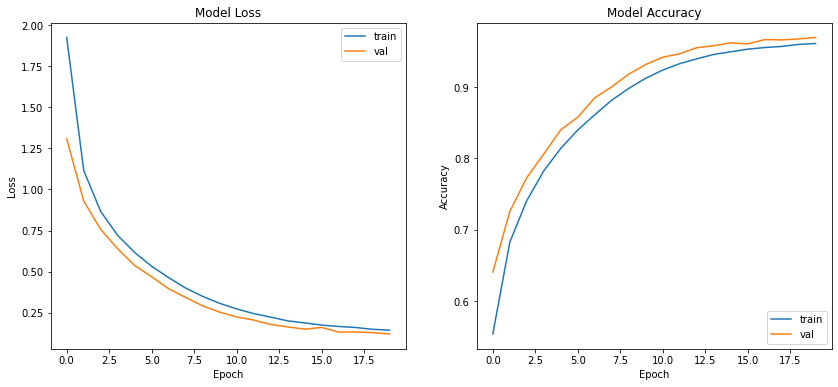

In [33]:
plot_stats(history.history["loss"],
           history.history["val_loss"],
           history.history["accuracy"],
           history.history["val_accuracy"])

Define a function that gets an input sentence in english and gives the output sentence in the french language.

In [36]:
#Test Your Zaka

def translate(eng_sent):

    input_pred_sequences = input_vectorizer(
        tf.reshape(
            tf.ragged.constant(eng_sent),
            (-1, 1)
        )
    )
    input_pred_sequences = pds(
        sequences=list(input_pred_sequences),
        maxlen=max_length_ENG,
        padding="post",
    )                                                                                           
    prediction_ids = model.predict(input_pred_sequences)
    
    output_vocab = np.array(output_vectorizer.get_vocabulary())
    return ' '.join([output_vocab[prediction] for prediction in np.argmax(prediction_ids[0], 1)])

Test the following sentence

In [37]:
input = "she is driving the truck"

#Test Your Zaka
translate(input)

1/1 [==============================] - 2s 2s/step


'elle conduit le camion blanc rouillé               '

Try to improve your model by modifying the architecture to take into account bidirectionality which is very useful in Machine Translation. Create a new model called model2

In [38]:
# creating model2 layers
in_vocab_size = len(input_vectorizer.get_vocabulary())
out_vocab_size = len(output_vectorizer.get_vocabulary())


input_sequence = Input(shape=(max_length_ENG,))

from tensorflow.keras.layers import Bidirectional

embedding = Embedding(
    input_dim=in_vocab_size,
    output_dim=128,
    embeddings_initializer=tf.keras.initializers.GlorotUniform,
    mask_zero=True
)

encoder = Bidirectional(LSTM(64, return_sequences=False))
repeat_vector = RepeatVector(max_length_FR)
decoder = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2))
logits = TimeDistributed(Dense(out_vocab_size))
output_layer = Dense(out_vocab_size, activation='softmax')


# Build the model2
x = input_sequence
x = embedding(x)
x = Masking()(x)
x = encoder(x)
x = repeat_vector(x)
x = decoder(x)
x = logits(x)

model2 = Model(inputs=input_sequence, outputs=Activation("softmax")(x))

compile and train your new model.

In [39]:
model2.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 15)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           25856     
                                                                 
 masking_1 (Masking)         (None, 15, 128)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 repeat_vector_1 (RepeatVect  (None, 21, 128)          0         
 or)                                                             
                                                                 
 bidirectional_1 (Bidirectio  (None, 21, 128)          9881

In [40]:
# fit the model

early_stop = EarlyStopping(monitor='val_loss',
                           patience=3,
                           restore_best_weights=True)

history2 = model2.fit(x=input_sequences,
                    y=output_sequences,
                    validation_split=0.15,
                    batch_size=64,
                    epochs=20,
                    callbacks=[early_stop])

Epoch 1/20
1831/1831 [==============================] - 56s 22ms/step - loss: 1.5417 - accuracy: 0.6199 - val_loss: 0.9751 - val_accuracy: 0.7344
Epoch 2/20
1831/1831 [==============================] - 32s 18ms/step - loss: 0.7717 - accuracy: 0.7834 - val_loss: 0.5795 - val_accuracy: 0.8330
Epoch 3/20
1831/1831 [==============================] - 33s 18ms/step - loss: 0.4771 - accuracy: 0.8636 - val_loss: 0.3525 - val_accuracy: 0.9031
Epoch 4/20
1831/1831 [==============================] - 33s 18ms/step - loss: 0.3046 - accuracy: 0.9152 - val_loss: 0.2294 - val_accuracy: 0.9364
Epoch 5/20
1831/1831 [==============================] - 32s 18ms/step - loss: 0.2197 - accuracy: 0.9383 - val_loss: 0.1717 - val_accuracy: 0.9521
Epoch 6/20
1831/1831 [==============================] - 33s 18ms/step - loss: 0.1760 - accuracy: 0.9499 - val_loss: 0.1428 - val_accuracy: 0.9596
Epoch 7/20
1831/1831 [==============================] - 33s 18ms/step - loss: 0.1493 - accuracy: 0.9569 - val_loss: 0.1257 -

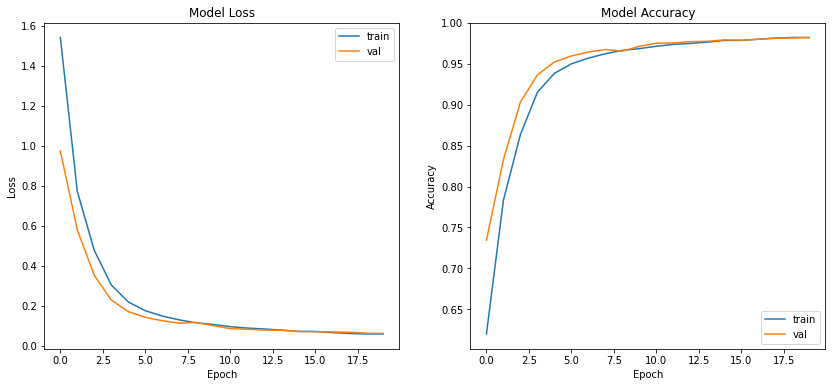

In [41]:
plot_stats(history2.history["loss"],
           history2.history["val_loss"],
           history2.history["accuracy"],
           history2.history["val_accuracy"])

More than 1% accuracy improvement!

Define a new function that relies on your new model to make predictions.

In [44]:
#Test Your Zaka
def new_model_translate(eng_sent):
    
    input_pred_sequences = input_vectorizer(
        tf.reshape(
            tf.ragged.constant(eng_sent),
            (-1, 1)
        )
    )
    input_pred_sequences = pds(
        sequences=list(input_pred_sequences),
        maxlen=max_length_ENG,
        padding="post",
    )                                                                                           
    prediction_ids = model2.predict(input_pred_sequences)
    
    output_vocab = np.array(output_vectorizer.get_vocabulary())
    return ' '.join([output_vocab[prediction] for prediction in np.argmax(prediction_ids[0], 1)])

In [45]:
input = "she is driving the truck"

#Test Your Zaka
new_model_translate(input)

1/1 [==============================] - 3s 3s/step


'elle aime le camion camion                '

**What is another adjustment in terms of architecture that you might be able to do to improve your model?**

One key idea is to use the attention mechanism: where the output context vector generated by the encoder of the input sequence can be exposed to the decoder in a way that the latter can focus on important parts of this sequence. This is done by calculating a set of attention weights through comparing current decoder state with each element of the input sequence. The aforementioned methodology solves the problem of long-term dependency of sequences.

Another one would be to use the transformer architecture instead of LSTM which is more powerful. Or simply use more LSTM layers.

**What are some additional ways that we can do to improve the performance of our model?**

- Perform hyperparameter tuning
- use more regularization techniques (dropouts, L2, BatchNormalization, ...)